In [15]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(patchwork)
library(smplot2)
suppressPackageStartupMessages(library(ggrepel))

library(ggpubr)

In [2]:
color_annotation<-read.csv('/home/jupyter/BRI_Figures_Final_V1/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [3]:
Y1D0<-read.csv('/home/jupyter/BRI_Figures_Final_V2/Figure2/02_DEG/Deseq2_Result_Y1D0.csv')
Y2D0<-read.csv('/home/jupyter/BRI_Figures_Final_V2/Extended_Figure2_1​/02-DEG_Y2D0/Deseq2_Result_Y2D0.csv')

In [4]:
deg_counts_df_Y1 <- Y1D0 %>%
  filter(contrast == 'cohort.cohortGuid') %>%
  mutate(Expression = case_when(
    log2FoldChange >= 0.1 & padj <= 0.05 ~ "Up-regulated",
    log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
    TRUE ~ "Unchanged"
  )) %>%
  group_by(celltype, Expression) %>%
  summarise(count = n(), .groups = 'drop') %>%
  complete(celltype, Expression, fill = list(count = 0)) %>% 
  filter(!Expression=="Unchanged")%>%  as.data.frame()%>%
  mutate(count = case_when(
    Expression == "Down-regulated" ~ -count,
    TRUE ~ count
  ))

deg_counts_df_Y2 <- Y2D0 %>%
  filter(contrast == 'cohort.cohortGuid') %>%
  mutate(Expression = case_when(
    log2FoldChange >= 0.1 & padj <= 0.05 ~ "Up-regulated",
    log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
    TRUE ~ "Unchanged"
  )) %>%
  group_by(celltype, Expression) %>%
  summarise(count = n(), .groups = 'drop') %>%
  complete(celltype, Expression, fill = list(count = 0)) %>% 
  filter(!Expression=="Unchanged")%>%  as.data.frame()%>%
  mutate(count = case_when(
    Expression == "Down-regulated" ~ -count,
    TRUE ~ count
  ))

In [5]:
colnames(deg_counts_df_Y1)[3]<-'Y1_DEG_Counts'
colnames(deg_counts_df_Y2)[3]<-'Y2_DEG_Counts'

In [6]:
df<-left_join(deg_counts_df_Y1,deg_counts_df_Y2)

Joining with `by = join_by(celltype, Expression)`


In [7]:
df[is.na(df)] <- 0

In [8]:
df <- df %>% filter(Y1_DEG_Counts != 0 | Y2_DEG_Counts != 0)

In [12]:
top_celltype<-c('Naive CD4 Treg',
'CM CD4 T cell',
'Core naive CD8 T cell',
'Core naive CD4 T cell')

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


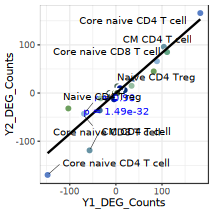

In [17]:

options(repr.plot.width = 45/25.4, repr.plot.height =45/25.4)

correlation_test <- cor.test(df$Y1_DEG_Counts, df$Y2_DEG_Counts,method='pearson')
correlation <- correlation_test$estimate
p_value <- correlation_test$p.value

p<-ggplot(data = df, mapping = aes(x = Y1_DEG_Counts, y = Y2_DEG_Counts)) +
  geom_point(aes(fill = celltype), shape = 21, color = "white", size = 1.5, show.legend = FALSE) + 
  geom_smooth(method = 'lm', color = "black", se=FALSE,linewidth = 0.5) +
  scale_fill_manual(values = color_vector) + 
  annotate("text",  
           x=0.2, 
           y=2,size=2,
           label = paste("r =", round(correlation, 2), 
                         "\np =",signif(p_value,3)), 
           vjust = 1.1,
           color = "blue") +
  geom_text_repel(
    data = df %>% filter(celltype%in% top_celltype),
    box.padding = 0.5,
    force = 0.5,
    max.overlaps = 50,
    nudge_x = 0.15,
    hjust = 0.1,
    segment.size = 0.1,
    mapping = aes(label = celltype),
    size = 2
  )+
theme_bw(base_size=6)
p
ggsave('FigureE.pdf',p,
       width = 50/25.4,
       height = 45/25.4)